In [26]:
# Import necessary libraries
import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from sklearn.model_selection import train_test_split


In [4]:
# Load the data from a CSV file
train_df = pd.read_csv("../Datasets/train.csv")

In [5]:
# Get an array of unique values from the "product_number" column of the train_df DataFrame
ids = train_df["product_number"].unique()


In [7]:
# Get a subset of the train_df DataFrame where the "product_number" column equals the first
# value in the ids array and return the resulting DataFrame.
train_df[train_df['product_number'] == ids[0]]


,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units,setmana
0,202119-6909,2021-05-15,202119,6909,93,Arale,21274,13.3,Premium,2.0,35.0,19
1,202120-6909,2021-05-22,202120,6909,93,Arale,21274,13.3,Premium,0.0,70.0,20
2,202121-6909,2021-05-29,202121,6909,93,Arale,21274,13.3,Premium,3.0,137.0,21
3,202122-6909,2021-06-05,202122,6909,93,Arale,21274,13.3,Premium,0.0,274.0,22
4,202123-6909,2021-06-12,202123,6909,93,Arale,21274,13.3,Premium,0.0,333.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...
132,202316-6909,2023-04-22,202316,6909,93,Arale,21274,13.3,Premium,NaN,23.0,16
133,202317-6909,2023-04-29,202317,6909,15,Arale,21274,13.3,Premium,143.0,58.0,17
134,202317-6909,2023-04-29,202317,6909,93,Arale,21274,13.3,Premium,0.0,32.0,17
135,202318-6909,2023-05-06,202318,6909,15,Arale,21274,13.3,Premium,16.0,62.0,18


In [6]:
# Create a new column in the train_df DataFrame named "setmana" that contains the
# last two characters of the "year_week" column converted to an integer datatype.
train_df['setmana'] = train_df['year_week'].map(lambda x: str(x)[-2:]).astype('int64')


In [8]:
# Get the datatypes from all the dataset
train_df.dtypes

id                  object
date                object
year_week            int64
product_number       int64
reporterhq_id        int64
prod_category       object
specs                int64
display_size       float64
segment             object
sales_units        float64
inventory_units    float64
setmana              int64
dtype: object

##### Exploratory cells

In [9]:
train_df[train_df['product_number'] == ids[40]]['reporterhq_id'].unique()

array([ 3, 60,  6], dtype=int64)

In [10]:
train_df["reporterhq_id"].unique()

array([93, 15, 90, 12, 78, 24,  3, 60,  6, 72, 21, 87, 48, 39, 27, 84, 36,
       96,  9, 81], dtype=int64)

In [11]:
train_df.groupby(['product_number', 'reporterhq_id']).size().reset_index(name='counts')

,product_number,reporterhq_id,counts
0,6909,15,47
1,6909,93,90
2,7896,15,47
3,7896,93,91
4,8883,90,95
...,...,...,...
294,242802,15,47
295,242802,93,90
296,247737,3,127
297,247737,15,48


In [13]:
train_df[train_df['product_number'] == 6909]

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units,setmana
0,202119-6909,2021-05-15,202119,6909,93,Arale,21274,13.3,Premium,2.0,35.0,19
1,202120-6909,2021-05-22,202120,6909,93,Arale,21274,13.3,Premium,0.0,70.0,20
2,202121-6909,2021-05-29,202121,6909,93,Arale,21274,13.3,Premium,3.0,137.0,21
3,202122-6909,2021-06-05,202122,6909,93,Arale,21274,13.3,Premium,0.0,274.0,22
4,202123-6909,2021-06-12,202123,6909,93,Arale,21274,13.3,Premium,0.0,333.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...
132,202316-6909,2023-04-22,202316,6909,93,Arale,21274,13.3,Premium,NaN,23.0,16
133,202317-6909,2023-04-29,202317,6909,15,Arale,21274,13.3,Premium,143.0,58.0,17
134,202317-6909,2023-04-29,202317,6909,93,Arale,21274,13.3,Premium,0.0,32.0,17
135,202318-6909,2023-05-06,202318,6909,15,Arale,21274,13.3,Premium,16.0,62.0,18


In [14]:
# Group the train_df DataFrame by the "id" column, calculate the sum of the "sales_units"
# and "inventory_units" columns for each group, reset the index, and select only the "id",
# "sales_units", and "inventory_units" columns from the resulting DataFrame.
df_sum = train_df.groupby(['id']).sum().reset_index().loc[:,['id', 'sales_units', 'inventory_units']]


C:\Users\berna\AppData\Local\Temp\ipykernel_11440\3727599589.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sum = train_df.groupby(['id']).sum().reset_index().loc[:,['id', 'sales_units', 'inventory_units']]


In [17]:
df_sum

,id,sales_units,inventory_units
0,201915-233919,2.0,20.0
1,201916-233919,3.0,43.0
2,201917-233919,122.0,184.0
3,201918-233919,61.0,219.0
4,201919-233919,33.0,133.0
...,...,...,...
7704,202318-92778,36.0,92.0
7705,202318-93765,47.0,31.0
7706,202318-94752,11.0,374.0
7707,202318-9870,10.0,111.0


In [18]:
# Drop "reporterhq_id", "sales_units", "inventory_units"
df_noReporter = train_df.drop(["reporterhq_id", "sales_units", "inventory_units"], axis = 1)

In [19]:
# Drop duplicates
df_noDupl = df_noReporter.drop_duplicates()

In [20]:
df_noDupl

,id,date,year_week,product_number,prod_category,specs,display_size,segment,setmana
0,202119-6909,2021-05-15,202119,6909,Arale,21274,13.3,Premium,19
1,202120-6909,2021-05-22,202120,6909,Arale,21274,13.3,Premium,20
2,202121-6909,2021-05-29,202121,6909,Arale,21274,13.3,Premium,21
3,202122-6909,2021-06-05,202122,6909,Arale,21274,13.3,Premium,22
4,202123-6909,2021-06-12,202123,6909,Arale,21274,13.3,Premium,23
...,...,...,...,...,...,...,...,...,...
15439,202314-247737,2023-04-08,202314,247737,Arale,10637,13.3,Premium,14
15442,202315-247737,2023-04-15,202315,247737,Arale,10637,13.3,Premium,15
15445,202316-247737,2023-04-22,202316,247737,Arale,10637,13.3,Premium,16
15448,202317-247737,2023-04-29,202317,247737,Arale,10637,13.3,Premium,17


In [21]:

# Merge the df_noDupl and df_sum DataFrames on the "id" column and store the resulting
# DataFrame in the new_df variable.
new_df = pd.merge(df_noDupl, df_sum, on = ['id', 'id'])


In [22]:
new_df

,id,date,year_week,product_number,prod_category,specs,display_size,segment,setmana,sales_units,inventory_units
0,202119-6909,2021-05-15,202119,6909,Arale,21274,13.3,Premium,19,2.0,35.0
1,202120-6909,2021-05-22,202120,6909,Arale,21274,13.3,Premium,20,0.0,70.0
2,202121-6909,2021-05-29,202121,6909,Arale,21274,13.3,Premium,21,3.0,137.0
3,202122-6909,2021-06-05,202122,6909,Arale,21274,13.3,Premium,22,0.0,274.0
4,202123-6909,2021-06-12,202123,6909,Arale,21274,13.3,Premium,23,0.0,333.0
...,...,...,...,...,...,...,...,...,...,...,...
7704,202314-247737,2023-04-08,202314,247737,Arale,10637,13.3,Premium,14,92.0,44.0
7705,202315-247737,2023-04-15,202315,247737,Arale,10637,13.3,Premium,15,20.0,30.0
7706,202316-247737,2023-04-22,202316,247737,Arale,10637,13.3,Premium,16,12.0,37.0
7707,202317-247737,2023-04-29,202317,247737,Arale,10637,13.3,Premium,17,12.0,65.0


In [24]:
# Drop sales_units
new_df = new_df.drop(['sales_units'],axis=1)
new_df

,id,date,year_week,product_number,prod_category,specs,display_size,segment,setmana,inventory_units
0,202119-6909,2021-05-15,202119,6909,Arale,21274,13.3,Premium,19,35.0
1,202120-6909,2021-05-22,202120,6909,Arale,21274,13.3,Premium,20,70.0
2,202121-6909,2021-05-29,202121,6909,Arale,21274,13.3,Premium,21,137.0
3,202122-6909,2021-06-05,202122,6909,Arale,21274,13.3,Premium,22,274.0
4,202123-6909,2021-06-12,202123,6909,Arale,21274,13.3,Premium,23,333.0
...,...,...,...,...,...,...,...,...,...,...
7704,202314-247737,2023-04-08,202314,247737,Arale,10637,13.3,Premium,14,44.0
7705,202315-247737,2023-04-15,202315,247737,Arale,10637,13.3,Premium,15,30.0
7706,202316-247737,2023-04-22,202316,247737,Arale,10637,13.3,Premium,16,37.0
7707,202317-247737,2023-04-29,202317,247737,Arale,10637,13.3,Premium,17,65.0


In [27]:
# One-hot encoder applied to "prod_category", "segment"
encoder = ce.OneHotEncoder(cols=["prod_category", "segment"])
print(new_df.columns)
new_df = encoder.fit_transform(new_df)


Index(['id', 'date', 'year_week', 'product_number', 'prod_category', 'specs',
       'display_size', 'segment', 'setmana', 'inventory_units'],
      dtype='object')


In [28]:
# Ordinal encoder applied to "specs"
encoder_ord = ce.OrdinalEncoder(cols=['specs'])
new_df = encoder_ord.fit_transform(new_df)

In [52]:
# Save the created dataset
new_df.to_csv('../Datasets/new_df.csv')

In [29]:
new_df

,id,date,year_week,product_number,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,specs,display_size,segment_1,segment_2,segment_3,setmana,inventory_units
0,202119-6909,2021-05-15,202119,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,19,35.0
1,202120-6909,2021-05-22,202120,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,20,70.0
2,202121-6909,2021-05-29,202121,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,21,137.0
3,202122-6909,2021-06-05,202122,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,22,274.0
4,202123-6909,2021-06-12,202123,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,23,333.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7704,202314-247737,2023-04-08,202314,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,14,44.0
7705,202315-247737,2023-04-15,202315,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,15,30.0
7706,202316-247737,2023-04-22,202316,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,16,37.0
7707,202317-247737,2023-04-29,202317,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,17,65.0


In [30]:
# Remove the "id" column from the new_df DataFrame.
new_df = new_df.drop(['id'], axis=1)

# Create a new column named "nweek" in the new_df DataFrame by extracting the last two
# characters of the "year_week" column and converting them to an integer datatype.
new_df['nweek'] = new_df['year_week'].map(lambda x: str(x)[-2:])
new_df['nweek'] = new_df['nweek'].astype(np.int64)

# Convert the "date" column in the new_df DataFrame to a datetime datatype, and create new
# columns for the year, month, and day.
new_df['date'] = pd.to_datetime(new_df['date'])
new_df['year'], new_df['month'], new_df['day'] = new_df['date'].dt.year, new_df['date'].dt.month, new_df['date'].dt.day

# Remove the "date" column from the new_df DataFrame.
new_df = new_df.drop(['date'], axis=1)

new_df


,year_week,product_number,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,specs,display_size,segment_1,segment_2,segment_3,setmana,inventory_units,nweek,year,month,day
0,202119,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,19,35.0,19,2021,5,15
1,202120,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,20,70.0,20,2021,5,22
2,202121,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,21,137.0,21,2021,5,29
3,202122,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,22,274.0,22,2021,6,5
4,202123,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,23,333.0,23,2021,6,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7704,202314,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,14,44.0,14,2023,4,8
7705,202315,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,15,30.0,15,2023,4,15
7706,202316,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,16,37.0,16,2023,4,22
7707,202317,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,17,65.0,17,2023,4,29


In [31]:

df_noNan = new_df.fillna(value=0)
df_noNan

,year_week,product_number,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,specs,display_size,segment_1,segment_2,segment_3,setmana,inventory_units,nweek,year,month,day
0,202119,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,19,35.0,19,2021,5,15
1,202120,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,20,70.0,20,2021,5,22
2,202121,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,21,137.0,21,2021,5,29
3,202122,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,22,274.0,22,2021,6,5
4,202123,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,23,333.0,23,2021,6,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7704,202314,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,14,44.0,14,2023,4,8
7705,202315,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,15,30.0,15,2023,4,15
7706,202316,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,16,37.0,16,2023,4,22
7707,202317,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,17,65.0,17,2023,4,29


In [79]:
X = df_noNan.drop(columns=['inventory_units'])
Y = df_noNan['inventory_units']
X
Y

0        35.0
1        70.0
2       137.0
3       274.0
4       333.0
        ...  
7704     44.0
7705     30.0
7706     37.0
7707     65.0
7708     79.0
Name: inventory_units, Length: 7709, dtype: float64

In [80]:
X_train, X_test, y_train, y_test   = train_test_split(X,Y,shuffle=True,random_state=69)

In [81]:
df_noNan.dtypes

year_week            int64
product_number       int64
prod_category_1      int64
prod_category_2      int64
prod_category_3      int64
prod_category_4      int64
prod_category_5      int64
prod_category_6      int64
prod_category_7      int64
specs                int32
display_size       float64
segment_1            int64
segment_2            int64
segment_3            int64
setmana              int64
inventory_units    float64
nweek                int64
year                 int64
month                int64
day                  int64
dtype: object

In [99]:
xgb_gpu = xgb.XGBRegressor(n_estimators =2000,
                        learning_rate= 0.15,
                        max_depth= 20,
                        min_child_weight = 1,
                        gamma = 0.0,
                        colsample_bytree=0.4,
                        sampling_method='gradient_based',
                        objective='reg:squarederror',
                        tree_method='gpu_hist',
                        enable_categorical='True')

xgb_normal = xgb.XGBRegressor(n_estimators = 300,
                              learning_boost = 0.15,
                              max_depth = 20,
                              min_child_weight = 1,
                              gamma = 0.0,
                              colsample_bytree = 0.4,
                              reg_alpha=1000)

grid_result_f = xgb_normal.fit(X_train, y_train)

[11:25:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "learning_boost" } are not used.



In [100]:
y_predicted_test = xgb_normal.predict(X_test)
y_predicted_train = xgb_normal.predict(X_train)

rms_test = mean_squared_error(y_test, y_predicted_test, squared=False)
rms_train = mean_squared_error(y_train, y_predicted_train, squared=False)
print(f'train: {rms_train}\ntest: {rms_test}')

train: 60.65388948869107
test: 71.75273503981735


In [168]:
xgb_sklearn = GradientBoostingRegressor(n_estimators = 300,
                              learning_rate = 0.5,
                              max_depth = 20,
                              min_impurity_decrease= 5,
                              min_samples_split=50,
                              min_samples_leaf=20,
                              max_features='sqrt',
                              max_leaf_nodes=500,
                              # min_weight_fraction_leaf=0.5,
                              # gamma = 0.0,
                            #   colsample_bytree = 0.4,
                              ccp_alpha=0.5)

grid_result_f_sklearn = xgb_sklearn.fit(X_train, y_train)

In [169]:
y_predicted_test = xgb_sklearn.predict(X_test)
y_predicted_train = xgb_sklearn.predict(X_train)

rms_test = mean_squared_error(y_test, y_predicted_test, squared=False)
rms_train = mean_squared_error(y_train, y_predicted_train, squared=False)
print(f'train: {rms_train}\ntest: {rms_test}')

train: 41.888384912774384
test: 69.6837875634649


In [172]:

gsc1 = GridSearchCV(
            estimator=GradientBoostingRegressor(),
            param_grid={"n_estimators": list(range(100,500,100)),
                        "learning_rate": [0.5,0.10,0.20],
                        "max_depth": [5,10,20],
                        'min_impurity_decrease':[2,5,10],
                        'min_samples_split':[10,50,100],
                        'min_samples_leaf':[10,20,50],
                        'max_features':['auto'],
                        'max_leaf_nodes':list(range(300,600,100)),
                        'ccp_alpha':[0.1,0.5]},
            cv=5, scoring='neg_root_mean_squared_error', verbose=5, n_jobs=-1)

grid_result1 = gsc1.fit(X_train, y_train)
#grid_result1_1 = gsc1.fit(X,y)


Fitting 5 folds for each of 5832 candidates, totalling 29160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | e

In [173]:
y_predicted_test = gsc1.predict(X_test)
y_predicted_train = gsc1.predict(X_train)

rms_test = mean_squared_error(y_test, y_predicted_test, squared=False)
rms_train = mean_squared_error(y_train, y_predicted_train, squared=False)
print(f'train: {rms_train}\ntest: {rms_test}')

train: 38.844086881775155
test: 64.94251343595465


In [174]:
gsc1.best_params_

{'ccp_alpha': 0.5,
 'learning_rate': 0.1,
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': 300,
 'min_impurity_decrease': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 100}

In [175]:
pickle_file = open('best_params_xgboost_2.pkl','wb')
pickle.dump(gsc1.best_params_,pickle_file)
pickle_file.close()

In [177]:
new_df = new_df.drop(columns=['year_week','month','day'])
new_df

,product_number,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,specs,display_size,segment_1,segment_2,segment_3,setmana,inventory_units,nweek,year
0,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,19,35.0,19,2021
1,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,20,70.0,20,2021
2,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,21,137.0,21,2021
3,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,22,274.0,22,2021
4,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,23,333.0,23,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7704,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,14,44.0,14,2023
7705,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,15,30.0,15,2023
7706,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,16,37.0,16,2023
7707,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,17,65.0,17,2023


In [244]:
X = new_df.drop(columns=['inventory_units','setmana'])
Y = new_df['inventory_units']
X
Y

0        35.0
1        70.0
2       137.0
3       274.0
4       333.0
        ...  
7704     44.0
7705     30.0
7706     37.0
7707     65.0
7708     79.0
Name: inventory_units, Length: 7709, dtype: float64

In [245]:
X

,product_number,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,specs,display_size,segment_1,segment_2,segment_3,nweek,year
0,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,19,2021
1,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,20,2021
2,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,21,2021
3,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,22,2021
4,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,23,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7704,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,14,2023
7705,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,15,2023
7706,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,16,2023
7707,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,17,2023


In [246]:
X_train, X_test, y_train, y_test   = train_test_split(X,Y,shuffle=True,random_state=69)

In [247]:
xgboost_sklearn_gooddf = GradientBoostingRegressor(**gsc1.best_params_)

result_f_sklearn_gooddf = xgboost_sklearn_gooddf.fit(X_train, y_train)

In [248]:
y_predicted_test = xgboost_sklearn_gooddf.predict(X_test)
y_predicted_train = xgboost_sklearn_gooddf.predict(X_train)

rms_test = mean_squared_error(y_test, y_predicted_test, squared=False)
rms_train = mean_squared_error(y_train, y_predicted_train, squared=False)
print(f'train: {rms_train}\ntest: {rms_test}')

train: 43.14793891737735
test: 64.92150249107544


In [187]:
X_train

,product_number,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,specs,display_size,segment_1,segment_2,segment_3,setmana,nweek,year
1061,25662,1,0,0,0,0,0,0,11,13.3,1,0,0,44,44,2021
6349,226023,0,0,0,0,1,0,0,88,15.6,0,1,0,35,35,2022
2238,62181,0,0,0,0,1,0,0,25,14.0,0,1,0,43,43,2022
2047,58233,1,0,0,0,0,0,0,23,13.3,1,0,0,42,42,2021
1066,25662,1,0,0,0,0,0,0,11,13.3,1,0,0,49,49,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,43428,0,0,0,0,1,0,0,17,15.6,0,1,0,17,17,2022
2667,80934,0,0,0,1,0,0,0,31,13.5,1,0,0,48,48,2022
4041,127323,0,0,1,0,0,0,0,50,15.6,0,0,1,10,10,2023
7371,239841,0,1,0,0,0,0,0,97,15.6,0,1,0,10,10,2023


In [313]:
test_df = pd.read_csv("../Datasets/test.csv")

In [314]:
test_df.dtypes

id    object
dtype: object

In [315]:
test_df["year"] = test_df["id"].apply(lambda x: x[:4]).astype(np.int64)
test_df["nweek"] = test_df["id"].apply(lambda x: x[4:6]).astype(np.int64)
test_df["product_number"] = test_df["id"].apply(lambda x: x.split('-')[1]).astype(np.int64)

In [316]:
test_df

,id,year,nweek,product_number
0,202319-105609,2023,19,105609
1,202319-107583,2023,19,107583
2,202319-10857,2023,19,10857
3,202319-109557,2023,19,109557
4,202319-112518,2023,19,112518
...,...,...,...,...
1295,202331-92778,2023,31,92778
1296,202331-93765,2023,31,93765
1297,202331-94752,2023,31,94752
1298,202331-9870,2023,31,9870


In [317]:
# print(new_df.shape)
# print(new_df.dtypes)
# print(test_df.shape)
# print(test_df.dtypes)
print(X.dtypes)



product_number       int64
prod_category_1      int64
prod_category_2      int64
prod_category_3      int64
prod_category_4      int64
prod_category_5      int64
prod_category_6      int64
prod_category_7      int64
specs                int32
display_size       float64
segment_1            int64
segment_2            int64
segment_3            int64
nweek                int64
year                 int64
dtype: object


In [318]:
X.columns

Index(['product_number', 'prod_category_1', 'prod_category_2',
       'prod_category_3', 'prod_category_4', 'prod_category_5',
       'prod_category_6', 'prod_category_7', 'specs', 'display_size',
       'segment_1', 'segment_2', 'segment_3', 'nweek', 'year'],
      dtype='object')

In [319]:
X.iloc[:,:-3]

,product_number,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,specs,display_size,segment_1,segment_2
0,6909,1,0,0,0,0,0,0,1,13.3,1,0
1,6909,1,0,0,0,0,0,0,1,13.3,1,0
2,6909,1,0,0,0,0,0,0,1,13.3,1,0
3,6909,1,0,0,0,0,0,0,1,13.3,1,0
4,6909,1,0,0,0,0,0,0,1,13.3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7704,247737,1,0,0,0,0,0,0,100,13.3,1,0
7705,247737,1,0,0,0,0,0,0,100,13.3,1,0
7706,247737,1,0,0,0,0,0,0,100,13.3,1,0
7707,247737,1,0,0,0,0,0,0,100,13.3,1,0


In [320]:
X

,product_number,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,specs,display_size,segment_1,segment_2,segment_3,nweek,year
0,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,19,2021
1,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,20,2021
2,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,21,2021
3,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,22,2021
4,6909,1,0,0,0,0,0,0,1,13.3,1,0,0,23,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7704,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,14,2023
7705,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,15,2023
7706,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,16,2023
7707,247737,1,0,0,0,0,0,0,100,13.3,1,0,0,17,2023


In [321]:
print(X.iloc[:,:-2].dtypes)


product_number       int64
prod_category_1      int64
prod_category_2      int64
prod_category_3      int64
prod_category_4      int64
prod_category_5      int64
prod_category_6      int64
prod_category_7      int64
specs                int32
display_size       float64
segment_1            int64
segment_2            int64
segment_3            int64
dtype: object


X

In [228]:
df_merge = X.drop(columns = ["setmana", "nweek", "year"])

In [232]:
df_merge = df_merge.drop_duplicates()

In [322]:
test_df = test_df.reset_index().merge(df_merge,on=['product_number']).set_index('index')
test_df

,id,year,nweek,product_number,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,specs,display_size,segment_1,segment_2,segment_3
index,,,,,,,,,,,,,,,,
0,202319-105609,2023,19,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
100,202320-105609,2023,20,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
200,202321-105609,2023,21,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
300,202322-105609,2023,22,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
400,202323-105609,2023,23,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,202327-99687,2023,27,99687,0,0,0,0,1,0,0,42,15.6,0,1,0
999,202328-99687,2023,28,99687,0,0,0,0,1,0,0,42,15.6,0,1,0
1099,202329-99687,2023,29,99687,0,0,0,0,1,0,0,42,15.6,0,1,0


In [324]:
test_df = test_df.sort_index()

In [325]:
test_df.product_number.unique

<bound method Series.unique of index
0       105609
1       107583
2        10857
3       109557
4       112518
         ...  
1295     92778
1296     93765
1297     94752
1298      9870
1299     99687
Name: product_number, Length: 1300, dtype: int64>

In [326]:
# test_df = test_df.drop(columns=['id'])
test_df.dtypes

id                  object
year                 int64
nweek                int64
product_number       int64
prod_category_1      int64
prod_category_2      int64
prod_category_3      int64
prod_category_4      int64
prod_category_5      int64
prod_category_6      int64
prod_category_7      int64
specs                int32
display_size       float64
segment_1            int64
segment_2            int64
segment_3            int64
dtype: object

In [327]:
X_test.dtypes

product_number       int64
prod_category_1      int64
prod_category_2      int64
prod_category_3      int64
prod_category_4      int64
prod_category_5      int64
prod_category_6      int64
prod_category_7      int64
specs                int32
display_size       float64
segment_1            int64
segment_2            int64
segment_3            int64
nweek                int64
year                 int64
dtype: object

<AxesSubplot:ylabel='Count'>

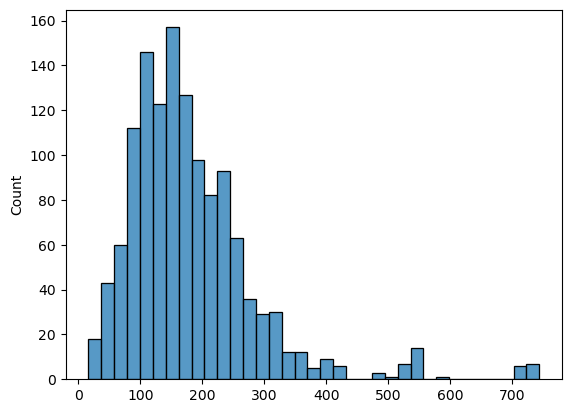

In [328]:

sns.histplot(y_predicted_test)

In [329]:
unique_pn = list(test_df.product_number.unique())

In [330]:
train_df

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units,setmana
0,202119-6909,2021-05-15,202119,6909,93,Arale,21274,13.3,Premium,2.0,35.0,19
1,202120-6909,2021-05-22,202120,6909,93,Arale,21274,13.3,Premium,0.0,70.0,20
2,202121-6909,2021-05-29,202121,6909,93,Arale,21274,13.3,Premium,3.0,137.0,21
3,202122-6909,2021-06-05,202122,6909,93,Arale,21274,13.3,Premium,0.0,274.0,22
4,202123-6909,2021-06-12,202123,6909,93,Arale,21274,13.3,Premium,0.0,333.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...
15449,202317-247737,2023-04-29,202317,247737,15,Arale,10637,13.3,Premium,0.0,62.0,17
15450,202317-247737,2023-04-29,202317,247737,24,Arale,10637,13.3,Premium,0.0,3.0,17
15451,202318-247737,2023-05-06,202318,247737,3,Arale,10637,13.3,Premium,22.0,0.0,18
15452,202318-247737,2023-05-06,202318,247737,15,Arale,10637,13.3,Premium,68.0,78.0,18


In [331]:
train_df[train_df['product_number'].isin(unique_pn)]

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units,setmana
0,202119-6909,2021-05-15,202119,6909,93,Arale,21274,13.3,Premium,2.0,35.0,19
1,202120-6909,2021-05-22,202120,6909,93,Arale,21274,13.3,Premium,0.0,70.0,20
2,202121-6909,2021-05-29,202121,6909,93,Arale,21274,13.3,Premium,3.0,137.0,21
3,202122-6909,2021-06-05,202122,6909,93,Arale,21274,13.3,Premium,0.0,274.0,22
4,202123-6909,2021-06-12,202123,6909,93,Arale,21274,13.3,Premium,0.0,333.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...
15449,202317-247737,2023-04-29,202317,247737,15,Arale,10637,13.3,Premium,0.0,62.0,17
15450,202317-247737,2023-04-29,202317,247737,24,Arale,10637,13.3,Premium,0.0,3.0,17
15451,202318-247737,2023-05-06,202318,247737,3,Arale,10637,13.3,Premium,22.0,0.0,18
15452,202318-247737,2023-05-06,202318,247737,15,Arale,10637,13.3,Premium,68.0,78.0,18


In [332]:
X[X['product_number'] == 105609]

,product_number,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,specs,display_size,segment_1,segment_2,segment_3,nweek,year
3511,105609,0,1,0,0,0,0,0,43,15.6,0,0,1,48,2021
3512,105609,0,1,0,0,0,0,0,43,15.6,0,0,1,49,2021
3513,105609,0,1,0,0,0,0,0,43,15.6,0,0,1,50,2021
3514,105609,0,1,0,0,0,0,0,43,15.6,0,0,1,51,2021
3515,105609,0,1,0,0,0,0,0,43,15.6,0,0,1,52,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3581,105609,0,1,0,0,0,0,0,43,15.6,0,0,1,14,2023
3582,105609,0,1,0,0,0,0,0,43,15.6,0,0,1,15,2023
3583,105609,0,1,0,0,0,0,0,43,15.6,0,0,1,16,2023
3584,105609,0,1,0,0,0,0,0,43,15.6,0,0,1,17,2023


In [333]:
test_df[test_df['product_number'] == 105609]

,id,year,nweek,product_number,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,specs,display_size,segment_1,segment_2,segment_3
index,,,,,,,,,,,,,,,,
0,202319-105609,2023,19,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
100,202320-105609,2023,20,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
200,202321-105609,2023,21,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
300,202322-105609,2023,22,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
400,202323-105609,2023,23,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
500,202324-105609,2023,24,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
600,202325-105609,2023,25,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
700,202326-105609,2023,26,105609,0,1,0,0,0,0,0,43,15.6,0,0,1
800,202327-105609,2023,27,105609,0,1,0,0,0,0,0,43,15.6,0,0,1


In [334]:
test_df = test_df[X.columns]

In [335]:
y_predicted_test = xgboost_sklearn_gooddf.predict(test_df)


<AxesSubplot:ylabel='Count'>

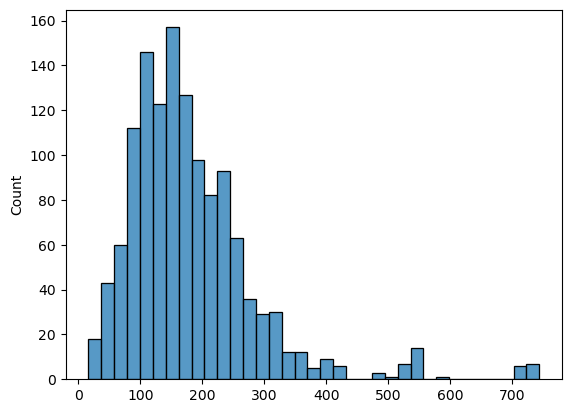

In [336]:
import seaborn as sns
sns.histplot(y_predicted_test)


In [337]:
y_predicted_test

array([ 87.64501898, 303.62516691, 179.47627314, ..., 191.54600157,
       159.23123562, 202.0010854 ])

In [338]:
test_df

,product_number,prod_category_1,prod_category_2,prod_category_3,prod_category_4,prod_category_5,prod_category_6,prod_category_7,specs,display_size,segment_1,segment_2,segment_3,nweek,year
index,,,,,,,,,,,,,,,
0,105609,0,1,0,0,0,0,0,43,15.6,0,0,1,19,2023
1,107583,0,0,0,0,1,0,0,44,15.6,0,1,0,19,2023
2,10857,0,0,1,0,0,0,0,5,15.6,0,0,1,19,2023
3,109557,0,1,0,0,0,0,0,45,14.0,0,1,0,19,2023
4,112518,0,0,0,1,0,0,0,46,15.6,1,0,0,19,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,92778,0,1,0,0,0,0,0,39,14.0,0,1,0,31,2023
1296,93765,1,0,0,0,0,0,0,40,14.0,1,0,0,31,2023
1297,94752,0,0,0,0,1,0,0,41,14.0,0,1,0,31,2023


In [339]:
test_df_just_for_id = pd.read_csv('../Datasets/test.csv')
test_df_just_for_id[test_df_just_for_id['id'] == str(f'202327-99687')]

,id
899,202327-99687


In [342]:

submission = pd.DataFrame({
    'id' : test_df_just_for_id.id,
    'inventory_units' : y_predicted_test
})
submission

,id,inventory_units
0,202319-105609,87.645019
1,202319-107583,303.625167
2,202319-10857,179.476273
3,202319-109557,100.942812
4,202319-112518,287.229260
...,...,...
1295,202331-92778,101.898371
1296,202331-93765,109.918336
1297,202331-94752,191.546002
1298,202331-9870,159.231236


In [344]:
submission.to_csv('../submissions/submission1.csv', index = False)